# 3. Keras Model

Create a simple Deep Learning Model using Keras

In [1]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/usr/local/cuda-11.1"

In [2]:
import pandas as pd
import numpy as np

from IPython.display import Markdown

import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


2023-01-01 10:57:17.029952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 10:57:18.142422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:57:18.142520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:57:18.142527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## 3.1. Data Collection

In [3]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df_source.drop_duplicates(inplace=True)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())

(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


## 3.2 Data Preparation & Cleaning

### 3.2.1 Add the Target Variable

In [4]:
def add_is_fraud(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates
    0: No Fraud and 1: Fraud

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    """
    df_data['is_fraud'] = df_data['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
    return df_data

df_data = df_source.reset_index(drop=True)
add_is_fraud(df_data)
df_data['is_fraud'].value_counts()

0    176457
1      4062
Name: is_fraud, dtype: int64

### 3.2.2 Data Selection

Select the subset of columns to use for training the model.

In [5]:
df_data = df_data \
    .filter([
        'is_fraud',
        'Customer Id',
        'Order Id',
        'Type',
        'Customer Country',
        'Customer State',
        'Customer City',
        #'Customer Street',
        'Order Country',
        'Order State',
        'order date (DateOrders)',
        'Sales per customer'
    ])

print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(180519, 11)


,is_fraud,Customer Id,Order Id,Type,Customer Country,Customer State,Customer City,Order Country,Order State,order date (DateOrders),Sales per customer
0,0,20755,77202,DEBIT,Puerto Rico,PR,Caguas,Indonesia,Java Occidental,1/31/2018 22:56,314.640015
1,0,19492,75939,TRANSFER,Puerto Rico,PR,Caguas,India,Rajastán,1/13/2018 12:27,311.359985
2,0,19491,75938,CASH,EE. UU.,CA,San Jose,India,Rajastán,1/13/2018 12:06,309.720001
3,0,19490,75937,DEBIT,EE. UU.,CA,Los Angeles,Australia,Queensland,1/13/2018 11:45,304.809998
4,0,19489,75936,PAYMENT,Puerto Rico,PR,Caguas,Australia,Queensland,1/13/2018 11:24,298.250000


### 3.2.3. Summarize Data

In [6]:
# group the data and get the order total
df_order_total = df_data \
    .groupby(['Customer Id', 'Order Id'], as_index=False) \
    .agg({'Sales per customer': 'sum'}) \
    .rename(columns={'Sales per customer': 'order_total'}) \
    .sort_values(by=['Customer Id', 'Order Id'], ascending=True) \
    .reset_index(drop=True)

df_order_total.head()

,Customer Id,Order Id,order_total
0,1,22945,472.450012
1,2,15192,84.970001
2,2,33865,506.970016
3,2,57963,674.740013
4,2,67863,351.980011


In [7]:
# group the data and get the cumulative sales per customer
df_order_total['sales_per_customer'] = df_order_total \
    .groupby('Customer Id') \
    ['order_total'].cumsum().sort_values(ascending=False)

df_order_total[df_order_total['Customer Id'] == 918]

,Customer Id,Order Id,order_total,sales_per_customer
4228,918,11,846.800003,846.800003
4229,918,8555,661.110016,1507.910019
4230,918,42147,309.189995,1817.100014


In [8]:
# join to the original dataset
df_data = df_data \
    .drop(columns=['Sales per customer']) \
    .merge(df_order_total, on=['Customer Id', 'Order Id'], how='left') \
    .drop_duplicates() \
    .sort_values(by=['Customer Id', 'Order Id'], ascending=True) \
    .reset_index(drop=True)

print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(65752, 12)


,is_fraud,Customer Id,Order Id,Type,Customer Country,Customer State,Customer City,Order Country,Order State,order date (DateOrders),order_total,sales_per_customer
0,0,1,22945,DEBIT,EE. UU.,TX,Brownsville,India,Maharashtra,12/1/2015 22:18,472.450012,472.450012
1,0,2,15192,PAYMENT,EE. UU.,CO,Littleton,Alemania,Bavaria,8/10/2015 18:05,84.970001,84.970001
2,0,2,33865,DEBIT,EE. UU.,CO,Littleton,Estados Unidos,Nueva York,5/9/2016 8:04,506.970016,591.940018
3,0,2,57963,DEBIT,EE. UU.,CO,Littleton,Honduras,Cortés,4/26/2017 2:40,674.740013,1266.680031
4,0,2,67863,DEBIT,EE. UU.,CO,Littleton,Italia,Lacio,9/17/2017 15:04,351.980011,1618.660042


### 3.2.4 Configure Data Types

#### 3.2.4.1 Data Columns

In [9]:
# set the order data to datetime
df_data['order_date'] = pd.to_datetime(df_data['order date (DateOrders)'])
df_data.drop(columns=['order date (DateOrders)'], inplace=True)

#### 3.2.4.2 Categorical Columns

In [10]:
cat_columns = {
        'Type': 'payment_type',
        'Customer Country': 'customer_country',
        'Customer State': 'customer_state',
        'Customer City': 'customer_city',
        #'Customer Street': 'customer_street',
        'Order Country': 'order_country', 
        'Order State': 'order_state',
}

def convert_categorical(df_data: pd.DataFrame, cat_columns: dict) -> pd.DataFrame:
    """
    Convert the categorical columns to numeric

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    cat_columns : dict
        The dictionary of categorical columns

    Returns
    -------
    pd.DataFrame
        The dataframe with the columns converted to categorical and renamed.
    """
    df_output = df_data.copy()
    
    # convert the column to categorical
    for key, value in cat_columns.items():
        df_output[key] = df_output[key].astype('category')

    # rename the columns
    df_output.rename(columns=cat_columns, inplace=True)

    return df_output

df_data = convert_categorical(df_data, cat_columns)

In [11]:
df_data.dtypes

is_fraud                       int64
Customer Id                    int64
Order Id                       int64
payment_type                category
customer_country            category
customer_state              category
customer_city               category
order_country               category
order_state                 category
order_total                  float64
sales_per_customer           float64
order_date            datetime64[ns]
dtype: object

In [12]:
# show a summary of the categorical columns
df_data \
    .filter([
        'payment_type',
        'customer_country',
        'customer_state',
        'customer_city',
        'customer_street',
        'order_country',
        'order_state',
    ]) \
    .describe(
        include='all',
        datetime_is_numeric=True)

,payment_type,customer_country,customer_state,customer_city,order_country,order_state
count,65752,65752,65752,65752,65752,65752
unique,4,2,46,563,164,1089
top,DEBIT,EE. UU.,PR,Caguas,Estados Unidos,Inglaterra
freq,25340,40440,25312,24365,8270,2566


## 3.3 Feature Engineering

### 3.3.1 Remove Customer Id and Order Id

In [13]:
df_features = df_data \
    .drop(columns=[
        'Customer Id',
        'Order Id'
    ])

### 3.3.2 Add the date features

In [14]:
def add_date_features(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Add the date features

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe

    Returns
    -------
    pd.DataFrame
        The dataframe with the data features added.
    """
    df_output = df_data.copy()

    # add the month of the year
    df_output['order_month_of_year'] = df_output['order_date'].dt.month
    df_output['order_month_of_year'] = df_output['order_month_of_year'].astype('category')

    # add the hour
    df_output['order_hour'] = df_output['order_date'].dt.hour
    df_output['order_hour'] = df_output['order_hour'].astype('category')

    # drop the oder date
    df_output.drop(columns=['order_date'], inplace=True)

    return df_output

df_features = add_date_features(df_features)

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())

(65752, 11)


,is_fraud,payment_type,customer_country,customer_state,customer_city,order_country,order_state,order_total,sales_per_customer,order_month_of_year,order_hour
0,0,DEBIT,EE. UU.,TX,Brownsville,India,Maharashtra,472.450012,472.450012,12,22
1,0,PAYMENT,EE. UU.,CO,Littleton,Alemania,Bavaria,84.970001,84.970001,8,18
2,0,DEBIT,EE. UU.,CO,Littleton,Estados Unidos,Nueva York,506.970016,591.940018,5,8
3,0,DEBIT,EE. UU.,CO,Littleton,Honduras,Cortés,674.740013,1266.680031,4,2
4,0,DEBIT,EE. UU.,CO,Littleton,Italia,Lacio,351.980011,1618.660042,9,15


In [15]:
def scale_features(df_data: pd.DataFrame) -> pd.DataFrame:
    df_output = df_data.copy()
    float_columns = df_output.select_dtypes(include='float64').columns

    # scale the features
    scaler = StandardScaler()
    df_output[float_columns] = scaler.fit_transform(df_output[float_columns])

    return df_output

df_features = scale_features(df_features)

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())

(65752, 11)


,is_fraud,payment_type,customer_country,customer_state,customer_city,order_country,order_state,order_total,sales_per_customer,order_month_of_year,order_hour
0,0,DEBIT,EE. UU.,TX,Brownsville,India,Maharashtra,-0.094294,-0.880812,12,22
1,0,PAYMENT,EE. UU.,CO,Littleton,Alemania,Bavaria,-1.301600,-1.190559,8,18
2,0,DEBIT,EE. UU.,CO,Littleton,Estados Unidos,Nueva York,0.013263,-0.785293,5,8
3,0,DEBIT,EE. UU.,CO,Littleton,Honduras,Cortés,0.535999,-0.245915,4,2
4,0,DEBIT,EE. UU.,CO,Littleton,Italia,Lacio,-0.469653,0.035454,9,15


### 3.3.3 One Hot Encode Categorical Columns

In [16]:
def one_hot_encode(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Perform one-hot encoding on the categorical columns 
    in the dataframe.

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe

    Returns
    -------
    pd.DataFrame
        The dataframe with the columns one-hot encoded.
    """
    df_output = df_data.copy()

    # one-hot encode the categorical columns
    for column in df_output.select_dtypes(include='category').columns:
        df_output = pd.concat([df_output, pd.get_dummies(df_output[column], prefix=column)], axis=1)
        df_output.drop(columns=[column], inplace=True)
        
    return df_output
    
df_features = one_hot_encode(df_features)

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())

(65752, 1907)


is_fraud  order_total  sales_per_customer  payment_type_CASH  \
0         0    -0.094294           -0.880812                  0   
1         0    -1.301600           -1.190559                  0   
2         0     0.013263           -0.785293                  0   
3         0     0.535999           -0.245915                  0   
4         0    -0.469653            0.035454                  0   

   payment_type_DEBIT  payment_type_PAYMENT  payment_type_TRANSFER  \
0                   1                     0                      0   
1                   0                     1                      0   
2                   1                     0                      0   
3                   1                     0                      0   
4                   1                     0                      0   

   customer_country_EE. UU.  customer_country_Puerto Rico  \
0                         1                             0   
1                         1                             0   
2                         1                             0   
3                         1                             0   
4                         1                             0   

   customer_state_91732  customer_state_95758  customer_state_AL  \
0                     0                     0                  0   
1                     0                     0                  0   
2                     0                     0                  0   
3                     0                     0                  0   
4                     0                     0                  0   

   customer_state_AR  customer_state_AZ  customer_state_CA  customer_state_CO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  1   
3                  0                  0                  0                  1   
4                  0                  0                  0                  1   

   customer_state_CT  customer_state_DC  customer_state_DE  customer_state_FL  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_GA  customer_state_HI  customer_state_IA  customer_state_ID  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_IL  customer_state_IN  customer_state_KS  customer_state_KY  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_LA  customer_state_MA  customer_state_MD  customer_state_MI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0           

### 3.3.4 Normalize the Data

In [17]:
def scale_features(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Scale the features in the dataframe.

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe

    Returns
    -------
    pd.DataFrame
        The dataframe with the columns scaled.
    """
    df_output = df_data.copy()
    float_columns = df_output.select_dtypes(include='float64').columns

    # scale the features
    scaler = StandardScaler()
    df_output[float_columns] = scaler.fit_transform(df_output[float_columns])

    return df_output

df_features = scale_features(df_features)

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())


(65752, 1907)


is_fraud  order_total  sales_per_customer  payment_type_CASH  \
0         0    -0.094294           -0.880812                  0   
1         0    -1.301600           -1.190559                  0   
2         0     0.013263           -0.785293                  0   
3         0     0.535999           -0.245915                  0   
4         0    -0.469653            0.035454                  0   

   payment_type_DEBIT  payment_type_PAYMENT  payment_type_TRANSFER  \
0                   1                     0                      0   
1                   0                     1                      0   
2                   1                     0                      0   
3                   1                     0                      0   
4                   1                     0                      0   

   customer_country_EE. UU.  customer_country_Puerto Rico  \
0                         1                             0   
1                         1                             0   
2                         1                             0   
3                         1                             0   
4                         1                             0   

   customer_state_91732  customer_state_95758  customer_state_AL  \
0                     0                     0                  0   
1                     0                     0                  0   
2                     0                     0                  0   
3                     0                     0                  0   
4                     0                     0                  0   

   customer_state_AR  customer_state_AZ  customer_state_CA  customer_state_CO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  1   
3                  0                  0                  0                  1   
4                  0                  0                  0                  1   

   customer_state_CT  customer_state_DC  customer_state_DE  customer_state_FL  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_GA  customer_state_HI  customer_state_IA  customer_state_ID  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_IL  customer_state_IN  customer_state_KS  customer_state_KY  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_LA  customer_state_MA  customer_state_MD  customer_state_MI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0           

In [18]:
df_features \
    .filter([
        'order_total',
        'sales_per_customer',
    ]) \
    .describe()

,order_total,sales_per_customer
count,6.575200e+04,6.575200e+04
mean,-5.187074e-18,-3.544501e-17
std,1.000008e+00,1.000008e+00
min,-1.543011e+00,-1.251712e+00
25%,-8.036654e-01,-8.127922e-01
50%,-1.457044e-01,-2.115171e-01
75%,6.807273e-01,5.760910e-01
max,7.059431e+00,6.285022e+00


## 3.4 Model Training & Parameter Tuning

In [19]:
random_state = 105

### 3.4.1 Data Selection

In [20]:
# split the data into train and test, and validation sets
df_train, df_test = train_test_split(df_features, test_size=0.2, random_state=random_state)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=random_state)

Markdown(f'''
| Dataset | Rows | Columns | Not Fraud | Fraud |
| ------- | ---- | ------- | --------- | ----- |
| Train | {df_train.shape[0]} | {df_train.shape[1]} | {df_train[df_train['is_fraud'] == 0].shape[0]} | {df_train[df_train['is_fraud'] == 1].shape[0]} |
| Validation | {df_val.shape[0]} | {df_val.shape[1]} | {df_val[df_val['is_fraud'] == 0].shape[0]} | {df_val[df_val['is_fraud'] == 1].shape[0]} |
| Test | {df_test.shape[0]} | {df_test.shape[1]} | {df_test[df_test['is_fraud'] == 0].shape[0]} | {df_test[df_test['is_fraud'] == 1].shape[0]} |
''')


| Dataset | Rows | Columns | Not Fraud | Fraud |
| ------- | ---- | ------- | --------- | ----- |
| Train | 42080 | 1907 | 41124 | 956 |
| Validation | 10521 | 1907 | 10284 | 237 |
| Test | 13151 | 1907 | 12856 | 295 |


In [21]:
# get the features and labels
x_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

x_val = df_val.drop(columns=['is_fraud'])
y_val = df_val['is_fraud']

x_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

In [22]:
# oversample minority class
ros = RandomOverSampler(random_state=random_state)

x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)

### 3.4.2 Model Definition

In [23]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-01-01 10:57:34.181944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 10:57:34.215766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 10:57:34.215980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 10:57:34.216440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

### 3.4.3 Model Compilation

In [24]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### 3.4.4 Model Training

In [25]:
# history = model.fit(
#     x_train,
#     y_train,
#     epochs=20,
#     batch_size=512,
#     validation_data=(x_val, y_val))

In [26]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val))

2023-01-01 10:57:35.617946: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1254117504 exceeds 10% of free system memory.
2023-01-01 10:57:36.187792: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1254117504 exceeds 10% of free system memory.


Epoch 1/20
 34/161 [=====>........................] - ETA: 0s - loss: 0.6864 - accuracy: 0.6069

2023-01-01 10:57:37.592681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/161 [==============================] - 2s 9ms/step - loss: 0.6709 - accuracy: 0.7738 - val_loss: 0.6528 - val_accuracy: 0.8644
Epoch 2/20
161/161 [==============================] - 1s 6ms/step - loss: 0.6279 - accuracy: 0.8704 - val_loss: 0.6087 - val_accuracy: 0.8688
Epoch 3/20
161/161 [==============================] - 1s 6ms/step - loss: 0.5757 - accuracy: 0.8711 - val_loss: 0.5557 - val_accuracy: 0.8686
Epoch 4/20
161/161 [==============================] - 1s 6ms/step - loss: 0.5142 - accuracy: 0.8714 - val_loss: 0.4968 - val_accuracy: 0.8686
Epoch 5/20
161/161 [==============================] - 1s 6ms/step - loss: 0.4492 - accuracy: 0.8714 - val_loss: 0.4401 - val_accuracy: 0.8686
Epoch 6/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3900 - accuracy: 0.8715 - val_loss: 0.3940 - val_accuracy: 0.8707
Epoch 7/20
161/161 [==============================] - 1s 6ms/step - loss: 0.3445 - accuracy: 0.8716 - val_loss: 0.3641 - val_accuracy: 0.8690
Epoch 8/20
161/16

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

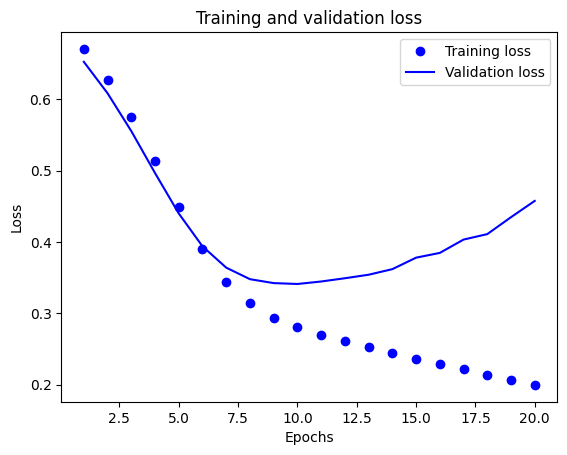

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# plot the history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


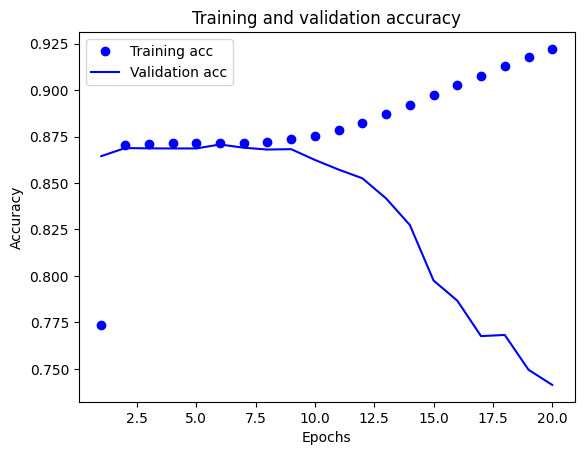

In [29]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
results = model.evaluate(x_test, y_test)
results

411/411 [==============================] - 1s 1ms/step - loss: 0.2590 - accuracy: 0.8393


[0.2589864432811737, 0.8393278121948242]

In [31]:
y_score = model.predict(x_test).ravel()
df_score = pd.DataFrame({
    'y_true': y_test,
    'y_score': y_score,
    'y_pred': y_score > 0.5,
})

confusion_matrix = pd.crosstab(df_score['y_true'], df_score['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)


411/411 [==============================] - 0s 839us/step
Predicted  False  True
Actual                
0          10872  1984
1            129   166


## PaRTy Plots

In [32]:
def calculate_class_metrics(
        predicted : pd.DataFrame, selected_class : str) -> pd.DataFrame:
    """
    Calculate precision and recall for the given class for difference
    confidence levels.
    """
    # find false positive rate for the selected class
    detection_rates = []
    step_size = 0.01

    # get the total number of true positives for the selected class
    total_tp = predicted \
        .query('y_true == @selected_class') \
        .shape[0]

    for current_conf in np.arange(0, 1, step_size):
        current_rate = {'confidence': current_conf}

        # get the number of true positives
        current_rate['tp'] = predicted \
            .query('y_pred == @selected_class ' + \
                   'and y_true == @selected_class ' + \
                   'and y_score >= @current_conf') \
            .shape[0]

        # get the number of false positives
        current_rate['fp'] = predicted \
            .query('y_pred == @selected_class ' + \
                   'and y_true != @selected_class ' + \
                   'and y_score >= @current_conf') \
            .shape[0]

        # calculate the precision
        if (current_rate['tp'] + current_rate['fp']) > 0:
            current_rate['precision'] = \
                current_rate['tp'] / (current_rate['tp'] + current_rate['fp'])

        # calculate the recall
        current_rate['recall'] = current_rate['tp'] / total_tp

        # add the results to the output
        detection_rates.append(current_rate)

    return pd.DataFrame(detection_rates)

In [33]:
def plot_class_metrics(detection_rates : pd.DataFrame, 
                       class_name : str = None) -> None:
    """
    Plots precision and recall for different confidence levels.
    """
    sns.set(rc = {'figure.figsize':(15,8)})

    ax = sns.lineplot(
        data=detection_rates,
        y='precision',
        x='confidence',
        label='precision')

    ax2 = ax.twinx()
    sns.lineplot(
        data=detection_rates,
        y='recall',
        x='confidence',
        color='orange',
        ax=ax2,
        label='recall')

    ax.set_xlabel('Threshold')

    title = 'Precision and recall at different confidence levels'
    if class_name is not None:
        title = f'{class_name} :: {title}'

    ax.set_title(title)
    plt.show()

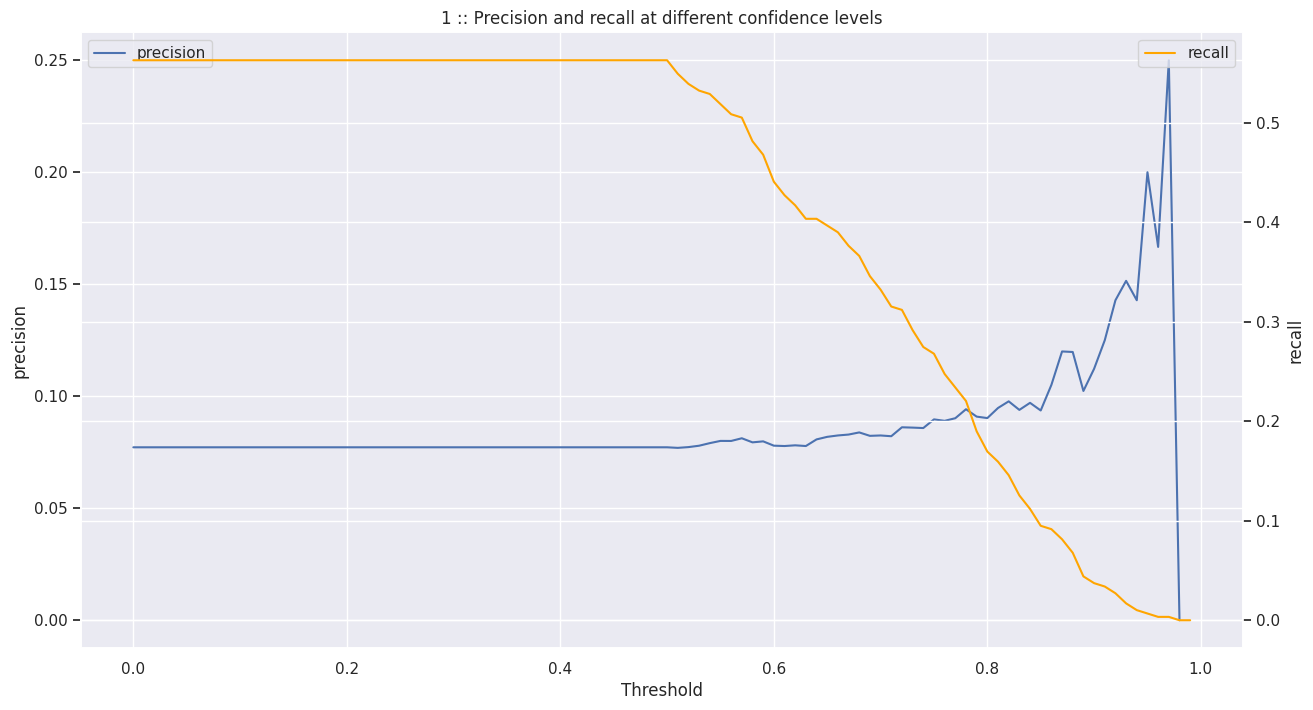

In [34]:
selected_class = 1
plot_class_metrics(
    calculate_class_metrics(df_score, selected_class),
    selected_class)

https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
https://scikit-learn.org/0.15/auto_examples/plot_roc.html

In [35]:
# y_pred = model.predict(x_test).ravel()
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# print(f'Area under the ROC curve: {roc_auc}')

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [36]:
# n_classes = 2
# y_score = model.predict(x_test)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
# #     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
# #     roc_auc[i] = auc(fpr[i], tpr[i])

# # # Compute micro-average ROC curve and ROC area
# # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])